# Computational Bionics: Project Exercise 1

Group members:
- Yash Waware
- Julian Lork
- Florian Frech (12308544)

------------------------
## Task 1: Modeling the Leg
### 1.1 Description

The following section considers an ODE model of the leg.

A test person with a body mass of $m_b = 100$ kg is chosen.

Following state variables are involved:
- $q_1$: Extension angle of the **hip** around then transversal axis ($xy$-plane)
- $\omega_1$: Angular velocity of the tight
- $q_2$: Rotation angle of the **knee** around the transversal axis ($xy$-plane) 
- $\omega_2$ Angular velocity of the shank

The segement masses are considered as point masses in the middle of each segment.

![](LowerLimb.png)

In this example the foot is treated as point mass located at the end of the shank.
Hence, we only consider two sections for the tigh and the shank with the corresponding flexion and extension angles $q_1$ and $q_2$

#### 1.2 Simplified Box Model

![](BoxModel_Task1.png)



### 1.3. Anthropometric Data

|Segment|Parameter|Symbol|Value|Unit|
|-------|-------- |------|----|----|
|Tigh   | Mass    | $m_1$ |9.73|kg|
|Tigh   | Length    | $L_1$ |0.410|m|
|Tigh   | Proximal COM| $l_1$ |0.205|m|
|Tigh   | Radius of Gyration| $r_{G1}$ |0.132|m|
|Tigh   | Moment of Inertia| $J_{1}$ |0.1695| kgm²|
|Tigh   | Viscous Damping Coefficient| $b_{2}$ |0.1| Nms|
|Shank   | Mass    | $m_2$ |5.07|kg|
|Shank   | Length    | $L_2$ |0.415|m|
|Shank   | Proximal COM| $l_2$ |0.2075|m|
|Shank   | Radius of Gyration| $r_{G1}$ |0.125|m|
|Shank   | Moment of Inertia| $J_{2}$ |0.0792| kgm²|
|Shank   | Viscous Damping Coefficient| $b_{2}$ |0.1| Nms|
|Foot   | Mass    | $m_3$ |0.44|kg|

Sources:

https://revistas.udistrital.edu.co/index.php/reving/article/view/20333/19807
https://personal.cityu.edu.hk/meachan/Online%20Anthropometry/Chapter2/Ch2-5.htm
https://pmc.ncbi.nlm.nih.gov/articles/PMC5305206/table/pone.0172112.t001/


### 1.4 Derivation

In [1]:
import sympy as sp
from sympy import sin, cos, Matrix, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

**Note:** $q_1, q_2$ correspond to $\theta_1, \theta_2$

In [54]:
# Define the symbolic variables
q1, q2, omega1, omega2 = sp.symbols(r'q_1 q_2 \omega_1 \omega_2')
dot_omega1, dot_omega2 = sp.symbols(r'\dot{\omega}_1 \dot{\omega}_2')
l1, l2, L1, L2 = sp.symbols(r'l_1 l_2 L_1 L_2')
m1, m2, m3 = sp.symbols(r'm_1 m_2 m_3')
J1, J2 = sp.symbols(r'J_1 J_2')
T1_sym, T2_sym = sp.symbols(r'T_1 T_2')
b1, b2 = sp.symbols(r'b_1 b_2')
t, g = sp.symbols('t g')

q1 = sp.Function('q_1')(t)
q2 = sp.Function('q_2')(t)

w1 = q1.diff(t)
w2 = q2.diff(t)

dot_w1 = w1.diff(t)
dot_w2 = w2.diff(t)

**Position vectors** to the centre of mass of tight $r_1$, shank $r_2$, and foot $r_3$ with respect to the hip $H$

$$
\mathbf{r}_{1} = 0.5 \cdot L_1 \cdot \begin{bmatrix} 
                   \cos q_1 \\
                   \sin q_1 \\
                   0 \end{bmatrix} \quad \quad

\mathbf{r}_{2} = \begin{bmatrix}
                   L_1 \cos q_1 + 0.5 \cdot L_2 \cos q_2 \\
                   L_1 \sin q_1 + 0.5 \cdot L_2 \sin q_2 \\
                   0 \end{bmatrix} \quad \quad

\mathbf{r}_{3} = \begin{bmatrix}
                   L_1 \cos q_1 + L_2 \cos q_2 \\
                   L_1 \sin q_1 + L_2 \sin q_2 \\
                   0 \end{bmatrix} \quad \quad                   
$$

In [55]:
# Position of the center of mass for tigh, shank and foot
r1 = Matrix([l1 * sin(q1),
             -l1 * cos(q1)])

r2 = Matrix([L1 * sin(q1) + l2 * sin(q2),
             -L1 * cos(q1) - l2 * cos(q2)])

r3 = Matrix([L1 * sin(q1) + L2 * sin(q2),
            -L1 * cos(q1) - L2 * cos(q2)])

In [56]:
# # Position vectors
# r1 = sp.Matrix([0.5 * L1 * sp.cos(q1),
#                   0.5 * L1 *sp.sin(q1),
#                   0])

# r2 = sp.Matrix([L1 * sp.cos(q1) + 0.5 * L2 * sp.cos(q2),
#                   L1 * sp.sin(q1) + 0.5 * L2 * sp.sin(q2),
#                   0])

# r3 = sp.Matrix([L1 * sp.cos(q1) + L2 * sp.cos(q2),
#                  L1 * sp.sin(q1) + L2 * sp.sin(q2),
#                  0])

**Velocity vectors** to the centre of mass of tight $SO$, shank $SU$, and foot $S$ with $\dot{q}_i = \omega_i$

$$
\mathbf{v}_{1} = 0.5 \cdot L_1 \cdot \dot{q}_1\begin{bmatrix} - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} = 0.5 \cdot L_1 \cdot \omega_1\begin{bmatrix} - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix}
$$

$$
\mathbf{v}_{2} = L_1 \cdot \dot{q}_1 \begin{bmatrix}  - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} + 0.5 \cdot L_2 \cdot \dot{q}_2 \begin{bmatrix}  - \sin q_2 \\ \cos q_2 \\ 0 \end{bmatrix} =
 L_1 \cdot \omega_1 \begin{bmatrix}  - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} + 0.5 \cdot L_2 \cdot \omega_2 \begin{bmatrix}  - \sin q_2 \\ \cos q_2 \\ 0 \end{bmatrix}
$$

$$
\mathbf{v}_{3} = L_1 \cdot \dot{q}_1 \begin{bmatrix}  - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} + L_2 \cdot \dot{q}_2 \begin{bmatrix}  - \sin q_2 \\ \cos q_2 \\ 0 \end{bmatrix}
= L_1 \cdot \omega_1 \begin{bmatrix}  - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} + L_2 \cdot \omega_2 \begin{bmatrix}  - \sin q_2 \\ \cos q_2 \\ 0 \end{bmatrix}
$$

$$\mathbf{v}_{1} = \omega_{1} l_{1} \left[\begin{matrix} \cos{\left(q_{1}{\left(t \right)} \right)}\\ \sin{\left(q_{1}{\left(t \right)} \right)}\end{matrix}\right]$$

$$\mathbf{v}_{2} = \left[\begin{matrix}L_{1} \omega_{1} \cos{\left(q_{1}{\left(t \right)} \right)} + \omega_{2} l_{2} \cos{\left(q_{2}{\left(t \right)} \right)}\\L_{1} \omega_{1} \sin{\left(q_{1}{\left(t \right)} \right)} + \omega_{2} l_{2} \sin{\left(q_{2}{\left(t \right)} \right)}\end{matrix}\right] $$

$$
\mathbf{v}_{3} = \left[\begin{matrix}L_{1} \omega_{1} \cos{\left(q_{1}{\left(t \right)} \right)} + L_{2} \omega_{2} \cos{\left(q_{2}{\left(t \right)} \right)}\\L_{1} \omega_{1} \sin{\left(q_{1}{\left(t \right)} \right)} + L_{2} \omega_{2} \sin{\left(q_{2}{\left(t \right)} \right)}\end{matrix}\right] $$

In [96]:
# Velocity of the center of mass for tigh, shank and foot
v1 = r1.diff(t)
v2 = r2.diff(t)
v3 = r3.diff(t)

# sp.print_latex(v3.subs({q1.diff(t): omega1, q2.diff(t): omega2}))

**Kinetic Energy T**

$$
T_1 = \frac{1}{2} m_1 \mathbf{v}_{1}^T \mathbf{v}_{1} + \frac{1}{2} \cdot J_1 \omega_1^2
$$

$$
T_2 = \frac{1}{2} m_2 \mathbf{v}_{2}^T \mathbf{v}_{2} + \frac{1}{2} \cdot J_2 \omega_2^2
$$

$$
T_3 = \frac{1}{2} m_3 \mathbf{v}_{3}^T \mathbf{v}_{3}
$$

In [97]:
# Kinetic energy of the system
T1 = 0.5 * m1 * v1.dot(v1) + 0.5 * J1 * q1.diff(t)**2
T2 = 0.5 * m2 * v2.dot(v2) + 0.5 * J2 * q2.diff(t)**2
T3 = 0.5 * m3 * v3.dot(v3)

T_total = T1 + T2 + T3

**Potential Energy V**

$$
V_1 = m_1 \cdot g \cdot 0.5 \cdot L_1 \cdot \sin q_1
$$

$$
V_2 = m_2 \cdot g \cdot ( L_1 \sin q_1 + 0.5 \cdot L_2 \sin q_2)
$$

$$
V_3 = m_3 \cdot g \cdot ( L_1 \sin q_1 + \cdot L_2 \sin q_2)
$$

In [98]:
# Potential energy of the system
h1 = -l1 * cos(q1)
h2 = -L1 * cos(q1) - l2 * cos(q2)
h3 = -L1 * cos(q1) - L2 * cos(q2)

V1 = m1 * g * h1
V2 = m2 * g * h2
V3 = m3 * g * h3

V_total = V1 + V2 + V3

In [99]:
# # Potential energy
# V1 = m1 * g * r1[1]
# V2 = m2 * g * r2[1]
# V3 = m3 * g * r3[1]
# V_total = V1 + V2 + V3

**Lagrangian**

$$L = T - V$$

$$
L = T_1 + T_2 + T_3 - V_1 - V_2 - V_3
$$

In [100]:
L = T_total - V_total

**Euler-Lagrange Formulation:**
$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_i} \right) - \frac{\partial L}{\partial q_i} = Q_i$$

$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_1} \right) - \frac{\partial L}{\partial q_1} = T_1 - b_1 \dot{q}_1 - b_2 (\dot{q}_1 - \dot{q}_2)$$

$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_2} \right) - \frac{\partial L}{\partial q_2} = T_2 - b_2 (\dot{q}_2 - \dot{q}_1)$$

- $q_i$: Set of the generalized coordinates
- $Q_i$: Set of external (non-conservative) forces applied to the system (2 DOF are associated with the hip and knee joint)
- $T_n$: Torque acting at each joint
- $b_n$: viscous damping coefficient

In [108]:
dL_d_dot_q1 = L.diff(q1.diff(t))
dL_d_dot_q2 = L.diff(q2.diff(t))

dL_d_dot_q1_dt = dL_d_dot_q1.diff(t)
dL_d_dot_q2_dt = dL_d_dot_q2.diff(t)

dL_dq1 = L.diff(q1)
dL_dq2 = L.diff(q2)

# Substitute the values of the parameters
subsDict = {q1.diff(t): omega1,
            q2.diff(t): omega2,
            q1.diff(t, 2): dot_omega1,
            q2.diff(t, 2): dot_omega2,}

dL_d_dot_q1_dt.subs(subsDict).simplify()
dL_d_dot_q2_dt.subs(subsDict).simplify()

dL_dq1.subs(subsDict).simplify()
dL_dq2.subs(subsDict).simplify();


*Approach 1:*

In [107]:
Q1 = T1_sym - b1 * q1.diff(t) - b2 * (q1.diff(t) - q2.diff(t))
Q2 = T2_sym - b2 * (q2.diff(t) - q1.diff(t))

Q1.subs(subsDict).simplify()
Q2.subs(subsDict).simplify();

*Approach 2:*

In [105]:
# Generalized for Q1 and Q2 - Variant 2
Q1_sym, Q2_sym = sp.symbols(r'Q_1 Q_2')

eq1_v2 = dL_d_dot_q1_dt - dL_dq1 - Q1_sym
eq2_v2 = dL_d_dot_q2_dt - dL_dq2 - Q2_sym

eq1_v2 = eq1_v2.subs(subsDict).simplify()
eq2_v2 = eq2_v2.subs(subsDict).simplify()

sol_v2 = sp.solve([eq1_v2, eq2_v2], [dot_omega1, dot_omega2])

# approx 35 seconds
dot_omega1_sol_v2 = sol_v2[dot_omega1].simplify()
dot_omega2_sol_v2 = sol_v2[dot_omega2].simplify()

**Setting up the system of equations:**


$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_1} \right) - \frac{\partial L}{\partial q_1} = T_1 - b_1 \dot{q}_1 - b_2 (\dot{q}_1 - \dot{q}_2) \quad \quad (I)$$

$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_2} \right) - \frac{\partial L}{\partial q_2} = T_2 - b_2 (\dot{q}_2 - \dot{q}_1) \quad \quad (II)$$

In [13]:
# Runtime: ~ 35 seconds

eq1 = dL_d_dot_q1_dt - dL_dq1 - Q1
eq2 = dL_d_dot_q2_dt - dL_dq2 - Q2

eq1 = eq1.subs(subsDict).simplify()
eq2 = eq2.subs(subsDict).simplify()

# Solve for omega1_dot and omega2_dot
sol = sp.solve([eq1, eq2], (dot_omega1, dot_omega2))

# Extracting and simplifying the solutions
dot_omega1_sol = sol[dot_omega1].simplify()
dot_omega2_sol = sol[dot_omega2].simplify()

**Defining the Parameters:**

In [77]:
m_body = 100 # Body mass [kg]
m1_val = 9.73; m2_val = 5.07; m3_val = 0.44 # Masses [kg]

L1_val = 0.41; l1_val = L1_val / 2 # Lengths thigh [m]
L2_val = 0.415; l2_val = L2_val / 2 # Lengths shank [m]

r_G1 = 0.132; r_G2 = 0.125 # Radius of gyration [m]
J1_val = m1_val * r_G1**2; J2_val = m2_val * r_G2**2 # Moments of inertia [kg m^2]

b1_val = 0.1; b2_val = 0.1 # Damping coefficients [N m s/rad]

g_val = 9.81 # Gravity [m/s^2]

# Subustitute dictionary
parameterDict = {m1: m1_val, m2: m2_val, m3: m3_val,
                L1: L1_val, l1: l1_val, L2: L2_val, l2: l2_val,
                J1: J1_val, J2: J2_val,
                b1: b1_val, b2: b2_val,
                g: g_val}

**Transform the obtained solution for $\dot{\omega}_i$ into a numerical function:**

*Approach 1:*

In [78]:
# Substitute the values of the parameters
dot_omega1_sol = dot_omega1_sol.subs(parameterDict)
dot_omega2_sol = dot_omega2_sol.subs(parameterDict)

# Lambdify the equations
dot_omega1_func = sp.lambdify((q1, q2, omega1, omega2, T1_sym, T2_sym), dot_omega1_sol, 'numpy')
dot_omega2_func = sp.lambdify((q1, q2, omega1, omega2, T1_sym, T2_sym), dot_omega2_sol, 'numpy')

*Approach 2:*

In [106]:
# Substitute the values of the parameters
dot_omega1_sol_v2 = dot_omega1_sol_v2.subs(parameterDict)
dot_omega2_sol_v2 = dot_omega2_sol_v2.subs(parameterDict)

# Lambdify the equations
dot_omega1_func_v2 = sp.lambdify((q1, q2, omega1, omega2, Q1_sym, Q2_sym), dot_omega1_sol_v2, 'numpy')
dot_omega2_func_v2 = sp.lambdify((q1, q2, omega1, omega2, Q1_sym, Q2_sym), dot_omega2_sol_v2, 'numpy')

**Read provided Gait Data File:**

<!-- ![](LegModel.png)

**General Note:** Relation between common measured joint angle and the chosen generalized coordinates

$$q_1 = \alpha_H + \frac{3}{2}\pi$$

$$q_2 = q_1 - \alpha_K = \alpha_H + \frac{3}{2}\pi - \alpha_K$$ -->

In [79]:
# Read gait data
filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd')

# Extract gait data
gait_step = np.array(gait_data["gait_%"]) / 100

GRFz = np.array(gait_data["GRFz[%BW]"]) * m_body * g_val / 100
GRFx = gait_data["GRFx[%BW]"] * m_body * g_val / 100

MX_H = np.array(gait_data["MX_H[Nm/kg]"]) * m_body
MX_K = np.array(gait_data["MX_K[Nm/kg]"]) * m_body
MX_F = np.array(gait_data["MX_F[Nm/kg]"]) * m_body

q1_gait = np.deg2rad(np.array(gait_data["Flex_Ext_H[deg]"]))
q2_gait = np.deg2rad(np.array(gait_data["Flex_Ext_K[deg]"]))

**Extra- and Interpolation of Gait Data**

In [80]:
# Precompute interpolating functions for M1 and M2
MX_H_interp = interp1d(gait_step, MX_H, kind='cubic', fill_value='extrapolate')
MX_K_interp = interp1d(gait_step, MX_K, kind='cubic', fill_value='extrapolate')

# Derivatives of MX_H and MX_K with respect to time using the interpolating functions
dMX_H_dt = np.gradient(MX_H_interp(gait_step), gait_step)
dMX_K_dt = np.gradient(MX_K_interp(gait_step), gait_step)

# Interpolating functions for derivatives of MX_H and MX_K
dMX_H_dt_interp = interp1d(gait_step, dMX_H_dt, kind='cubic', fill_value='extrapolate')
dMX_K_dt_interp = interp1d(gait_step, dMX_K_dt, kind='cubic', fill_value='extrapolate')

# Evaluate the interpolating functions at the gait time
dMX_H_dt_gait = dMX_H_dt_interp(gait_step)
dMX_K_dt_gait = dMX_K_dt_interp(gait_step)

# Interpolating functions for q1 and q2
q1_gait_interp = interp1d(gait_step, q1_gait, kind='cubic', fill_value='extrapolate')
q2_gait_interp = interp1d(gait_step, q2_gait, kind='cubic', fill_value='extrapolate')

# Derivatives of q1 and q2 with respect to time using the interpolated functions
dq1_dt = np.gradient(q1_gait_interp(gait_step), gait_step)
dq2_dt = np.gradient(q2_gait_interp(gait_step), gait_step)

# Interpolating functions for angular velocities
gait_omega1_interp = interp1d(gait_step, dq1_dt, kind='cubic', fill_value='extrapolate')
gait_omega2_interp = interp1d(gait_step, dq2_dt, kind='cubic', fill_value='extrapolate')

# Evaluate the interpolating functions at gait_step
gait_omega1 = gait_omega1_interp(gait_step)
gait_omega2 = gait_omega2_interp(gait_step)

**Defining Time Steps**

In [109]:
# Time step
dt = 0.01
t_start = 0
t_end = 1
t_eval = np.arange(t_start, t_end, dt)

**Initial Conditions**

*Approach 1:*

In [81]:
# initial conditions
q1_0 = q1_gait[0] # initial angle of the thigh
q2_0 = q2_gait[0] # initial angle of the shank

omega1_0 = gait_omega1[0]
omega2_0 = gait_omega2[0]

T1_0 = MX_H_interp(t_start)
T2_0 = MX_K_interp(t_start)

y0 = [omega1_0, omega2_0, q1_0, q2_0]

*Approach 2:*

In [110]:
Q1_0 = T1_0 - b1_val * omega1_0 - b2_val * (omega1_0 - omega2_0)
Q2_0 = T2_0 - b2_val * (omega2_0 - omega1_0)

y0_v2 = [omega1_0, omega2_0, q1_0, q2_0, Q1_0, Q2_0]

**ODE System of Equations**

*Approach 1:*

In [82]:
# Define the function to solve
def leg_model(t, y):
    omega1, omega2, q1, q2 = y

    T1 = MX_H_interp(t)
    T2 = MX_K_interp(t)

    domega1 = dot_omega1_func(q1, q2, omega1, omega2, T1, T2)
    domega2 = dot_omega2_func(q1, q2, omega1, omega2, T1, T2)

    dq1 = omega1
    dq2 = omega2

    return [domega1, domega2, dq1, dq2]

*Approach 2:*

In [111]:
# Define the function to solve
def leg_model_2(t, y):
    omega1, omega2, q1, q2, Q1, Q2 = y

    # Get the current external torques at knee and hip
    T1 = MX_H_interp(t)
    T2 = MX_K_interp(t)

    # Calculate the generalized torques Q1 and Q2
    Q1 = T1 - b1_val * omega1 - b2_val * (omega1 - omega2)
    Q2 = T2 - b2_val * (omega2 - omega1)

    # Calculate derivatives of angular velocities
    domega1 = dot_omega1_func_v2(q1, q2, omega1, omega2, Q1, Q2)
    domega2 = dot_omega2_func_v2(q1, q2, omega1, omega2, Q1, Q2)

    # Define the relationship between the generalized torques and the external torques
    dq1 = omega1
    dq2 = omega2

    dT1 = dMX_H_dt_interp(t)
    dT2 = dMX_K_dt_interp(t)

    dQ1 = dT1 - b1_val * domega1 - b2_val * (domega1 - domega2)
    dQ2 = dT2 - b2_val * (domega2 - domega1)

    return [domega1, domega2, dq1, dq2, dQ1, dQ2]

**Solving the System:**

*Approach 1:*

In [83]:
# Solve the ODE
sol = solve_ivp(leg_model, [t_start, t_end], y0, t_eval=t_eval, method='RK45')

# Extract the solution
t_sol = sol.t
omega1_sol = sol.y[0]
omega2_sol = sol.y[1]
q1_sol = sol.y[2]
q2_sol = sol.y[3]

*Approach 2:*

In [112]:
# Solve ODE with variant 2
sol_v2 = solve_ivp(leg_model_2, [t_start, t_end], y0_v2, t_eval=t_eval, method='RK45')

# Extract the solution v2
t_sol_v2 = sol_v2.t
omega1_sol_v2 = sol_v2.y[0]
omega2_sol_v2 = sol_v2.y[1]
q1_sol_v2 = sol_v2.y[2]
q2_sol_v2 = sol_v2.y[3]
Q1_sol_v2 = sol_v2.y[4]
Q2_sol_v2 = sol_v2.y[5]

**Plot the Results:**

*Approach 1:*

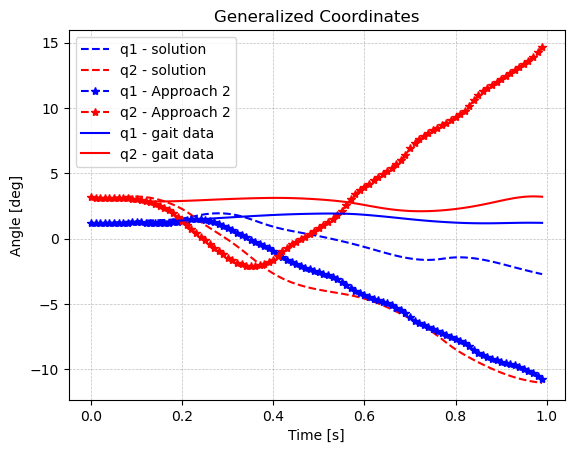

In [121]:
# plot the angles
plt.figure()
plt.title('Generalized Coordinates')
plt.plot(t_sol, q1_sol, 'b--', label='q1 - solution')
plt.plot(t_sol, q2_sol, 'r--', label='q2 - solution')
plt.plot(t_sol_v2, q1_sol_v2, 'b--*', label='q1 - Approach 2')
plt.plot(t_sol_v2, q2_sol_v2, 'r--*',label='q2 - Approach 2')
plt.plot(gait_step, q1_gait, 'b-', label='q1 - gait data')
plt.plot(gait_step, q2_gait, 'r-',label='q2 - gait data')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

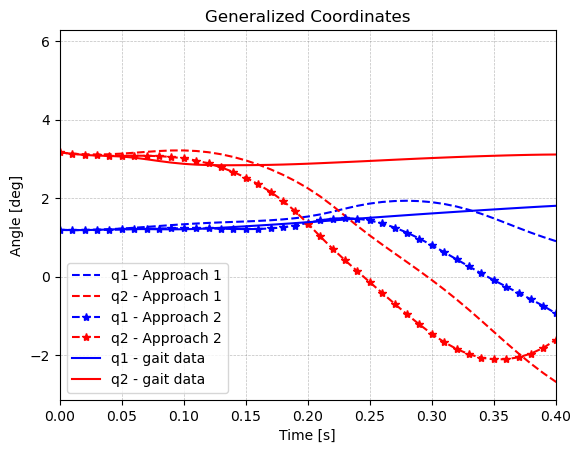

In [120]:
# plot the angles
plt.figure()
plt.title('Generalized Coordinates')
plt.plot(t_sol, q1_sol, 'b--', label='q1 - Approach 1')
plt.plot(t_sol, q2_sol, 'r--', label='q2 - Approach 1')
plt.plot(t_sol_v2, q1_sol_v2, 'b--*', label='q1 - Approach 2')
plt.plot(t_sol_v2, q2_sol_v2, 'r--*',label='q2 - Approach 2')
plt.plot(gait_step, q1_gait, 'b-', label='q1 - gait data')
plt.plot(gait_step, q2_gait, 'r-',label='q2 - gait data')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.ylim(-np.pi, 2*np.pi)
plt.xlim(0, 0.4)
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()


### 1.5 Results

+ The simulation data is only in a small range close to the provided gait data.
+ The angle around the hip $q_1$ shows already after 0.05 s significant deviations from the gait data.
+ The angle around the knee $q_2$ shows the significant deviations after 0.20 s.


-------------------------------------------------------

## Task 2: Modeling the drive
### 2.1 Description

The following section considers a dynamic model of the drive as an ODE model with the states motor current $I$ and motor torque $M$.

The motor **ILM-E50x08** from TQ systems is chosen as motor.

It is assumed, that this brushless drive operates in **star parallel configuration** and **operates like a brushed DC motor**. Hence, the we **approximate the *speed constant* $k_n$ by the *no load speed* over the rated voltage**.

A **motor voltage of 16 V** is chosen.

A gearbox with a gear **ratio $i_G$ of 60** and **efficiency of $\eta_G$ 0.85** is chosen.

|**Parameter**| **Symbol**|**Value**|
|-------------|-----------|---------|
|Operation Mode|-|Star Parallel|
|Motor Voltage| $U$ | $16 \space V$|
|Torque Constant|$k_M$| $30 \space mNm / A^2$|
|Terminal Resistance| $R_{TT}$ | $151 \space m\Omega$|
|Terminal Inductance| $L_{TT}$| $121 \space \mu H$|
|Gear Ratio| $i_G$ | $60$ |
|Gear Efficiency | $\eta_G$ | $0.85$ |
|Rotor Inertia| $J$ | $0.056 \space kgcm^2 $

### 2.2 Simplified Box Model

![](BoxModel_Task2.png)

### 2.3 Equations

#### 2.3.1 Motor Current Dynamics

The mesh equation for the motor is given by:

$$U = RI + L\frac{\partial I}{\partial t} + U_{ind}$$

with 

$$U_{ind} = \frac{\omega_M}{k_n}$$

where $\omega_M$ uis the motor angular frequency in rad/s and $k_n$ is the speed constant.

Since the brushless drive is assumed in star parallel configuration and it operates like a brushed DC motor, the speed constant can be approximated by the no load speed over the rated voltage.

$$k_n = \frac{n_{no-load}}{U} = \frac{12,916 \space rpm}{16 \space V} = \frac{12,916 \tfrac{rot}{min} \cdot 2 \pi}{60 \tfrac{s}{min} \cdot 16 \space V} = 84.53 \frac{rad}{Vs}$$

Substituting $U_{ind}$ yields:

$$U = RI + L\frac{\partial I}{\partial t} + \frac{\omega_M}{k_n}$$

Rearranging for $\frac{\partial I}{\partial t}$ we obtain:

$$\frac{\partial I}{\partial t} = \frac{1}{L} \cdot \left( U - RI - \frac{\omega_M}{k_n} \right)$$

#### 2.3.2 Motor Torque

The motor torque $M$ is related to the current $I$ via the torque constant $k_M$:

$$M = k_M \cdot I$$

where $k_M = 0.03 \space \frac{Nm}{A}$.

#### 2.3.3 Mechanical Dynamics

The mechanical dynamics of the motor (Newton's Law for rotation) are:

$$J\frac{d\omega_M}{dt} = M - T_{load}$$

where:
 + $J = 5.6 \cdot 10^{-4} \space kg m^2$ is the rotor inertia
 + $T_{load}$ is the load torque applied to the motor shaft

The load torque is related to the external load $T_{ext}$ through the gearbox:

$$T_{load} = \frac{T_{ext}}{i_G \cdot \eta_G}$$

where:
 + $i_G = 60$ is the gear ratio 
 + $\eta_G = 0.85$ is the gear efficiency

Substituting $T_{load}$ into the mechanical dynamics equation yields:

$$J\frac{d\omega_M}{dt} = M - \frac{T_{ext}}{i_G \cdot \eta_G}$$

Using $M = k_M \cdot I$ we obtain:

$$J\frac{d\omega_M}{dt} = k_M \cdot I - \frac{T_{ext}}{i_G \cdot \eta_G}$$

#### 2.3.4 Dynamic Model

We obtain the following ODEs for the system:

**1. Current Dynamics**
$$\frac{\partial I}{\partial t} = \frac{1}{L} \cdot \left( U - RI - \frac{\omega_M}{k_n} \right)$$

**2. Motor Torque**
$$M = k_M \cdot I$$

**3. Mechanical Dynamics**
$$J\frac{d\omega_M}{dt} = k_M \cdot I - \frac{T_{ext}}{i_G \cdot \eta_G}$$

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

In [143]:
# Parameters
U = 16 # V
R = 0.151 # Ohm
L = 121e-6 # H

k_n = 12916 * 2*np.pi / (60 * U) # rad/(Vs)
k_M = 0.03 # Nm/A

J = 5.6e-6 # kgm^2

i_G = 60 # gear ratio
eta_G = 0.85 # gear efficiency

filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd')
m_body = 100 # kg
MX_K = np.array(gait_data["MX_K[Nm/kg]"]) * m_body

T_ext = [0, 10, 30, 50] # Nm

print("Maximal Torque at the Knee: ", np.max(MX_K))

Maximal Torque at the Knee:  51.89301739334057


In [144]:
# dynamic model equations
def motor_model(t, y):
    I, omega_m, M, T_ext = y

    # Current dynamics
    dI_dt = (1/L) * (U - R*I - omega_m / k_n)

    # Mechanical dynamics
    M = k_M * I
    T_load = T_ext / (i_G * eta_G)
    
    domega_m_dt = (1/J) * (M - T_load)

    dM = k_M * dI_dt 

    return [dI_dt, domega_m_dt, dM, T_ext]

In [146]:
# Initial conditions
I0 = 0 
M0 = 0
omega_M0 = 0

y0 = []
for T in T_ext:
    y0.append([I0, omega_M0, M0, T])

# Time span
t_span = [0, 0.01]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve ODE
sol = []
for y0_i in y0:
    sol.append(solve_ivp(motor_model, t_span, y0_i, t_eval=t_eval, method='RK45'))

In [147]:
# Extract results
t = sol[0].t

I = [sol[i].y[0] for i in range(len(sol))]
omega_M = [sol[i].y[1] for i in range(len(sol))]
M = [sol[i].y[2] for i in range(len(sol))]

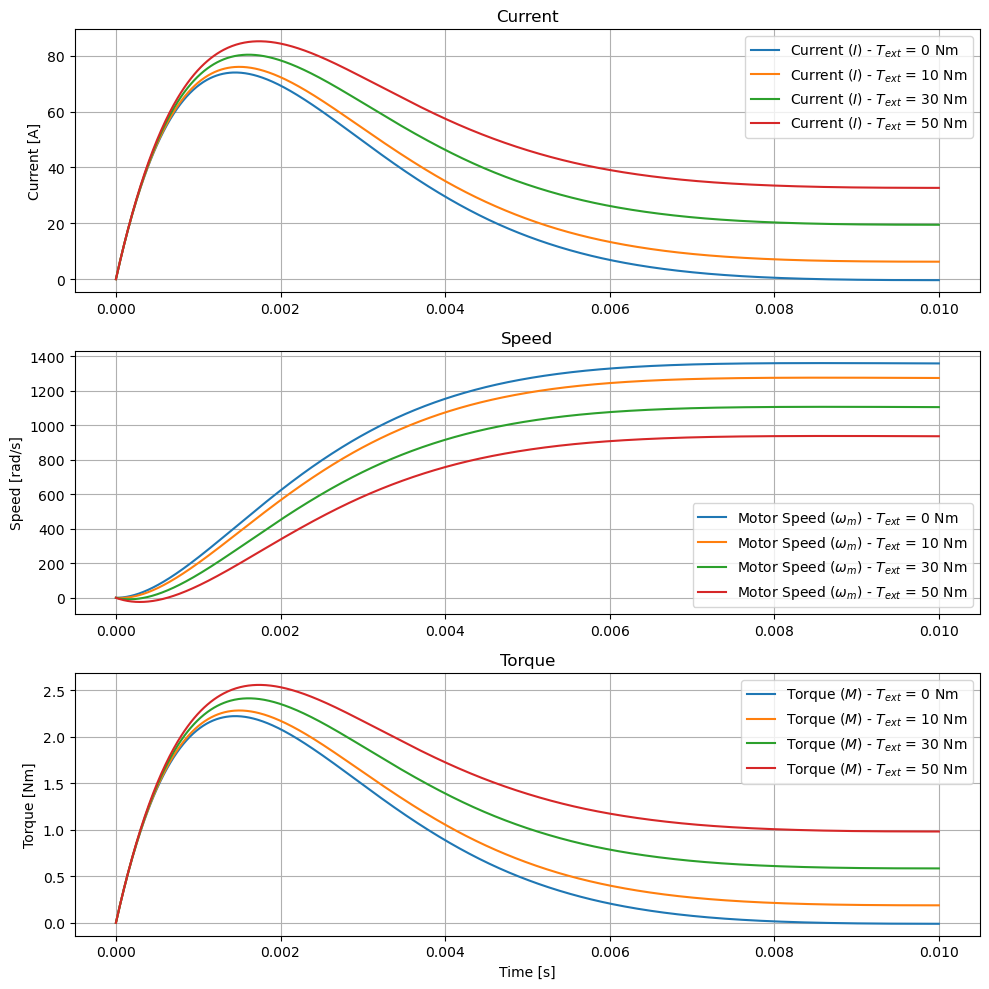

In [148]:
# Plot results
# Current plot
plt.figure(figsize=(10, 10))

# Currents
plt.subplot(3, 1, 1)
for i in range(len(T_ext)):
    plt.plot(t, I[i], label=r"Current ($I$) - $T_{ext}$ = " + str(T_ext[i]) + " Nm")
plt.ylabel("Current [A]")
plt.grid()
plt.title("Current")
plt.legend()

# Speed plot
plt.subplot(3, 1, 2)
for i in range(len(T_ext)):
    plt.plot(t, omega_M[i], label=r"Motor Speed ($\omega_m$) - $T_{ext}$ = " + str(T_ext[i]) + " Nm")
plt.ylabel("Speed [rad/s]")
plt.grid()
plt.title("Speed")
plt.legend()

# Torque plot
plt.subplot(3, 1, 3)
for i in range(len(T_ext)):
    plt.plot(t, M[i], label=r"Torque ($M$) - $T_{ext}$ = " + str(T_ext[i]) + " Nm")
plt.ylabel("Torque [Nm]")
plt.xlabel("Time [s]")
plt.grid()
plt.title("Torque")
plt.legend()


plt.tight_layout()
plt.show()

--------------------------------------------------------------

## Task 3: Modeling the Angle Sensor

### 3.1 Description

This section condiseders the modeling of an angle sensor for the knee as an algebraic model.

A potentiometer is chosen as sensor.

The measurement range for the angle sensor is chosen according to the range of motion of the knee, which is provided from the gait data.

The poteniometer requires a supply voltage $V_{in}$ of $5$ V and has an integrated µ-controller which has a maximum voltage input range of $3$ V.

The µ-controller uses an 8-bit analog digital converter for digitization of the input voltage.

| Variable | Discription | Value
|----------|----------|---------|
| $V_{out}$    | Output Voltage   | ...|
| $V_{in}$  | Input Voltage   | $5V$|
|$V_{micro}$ |Input Voltage microcontroller | $3V$ |
| $R_{pot}$   | Variable resistance of Potentiometer  | ...|
|$\alpha_{max}| Angular range of Potentiometer |$270°$|
|$R_{fixed}$ |Fixed resistance | $60k\Omega$ |
|$K_{deg}$ |Knee range of motion| $119.7^\circ$ to $184.9^\circ$ |
|$M$ |Microcontroller 8 bit ADC| 0 to 255 |

### 3.2 Simplified Box Model

![](BoxModel_Task3.png)

### 3.3 Equations: Potentiometer in a Measuring Bridge (Wheatstone)

The potentimeter can be used with a measuring bridge, where $Z_i = R_i$ since there is only equivalent current and $R_1$ and $R_2$ correspond to the potentimeter such that

$$R_{pot} = R_1 + R_2$$

![](MeasuringBridge.png)


The amplifier voltage, which is used as input voltag for the µ-controller is given as:

$$U_a = U_0 \cdot \left( \frac{R_2}{R_1+R_2} - \frac{R_4}{R_3+R_4} \right)$$

Substituting $R_{pot} = R_1 + R_2$ yields:

$$U_a = U_0 \cdot \left( \frac{R_2}{R_{pot}} - \frac{R_4}{R_3+R_4} \right)$$

The resistance of the potentimeter depends linearly on the rotation angle $\theta$. $R_1$ and $R_2$ can be rewritten as:

$$R_1 = \frac{\theta}{\theta_{max}} \cdot R_{pot} \quad \quad R_2 = R_{pot} - R_1$$

Inserting these expressions for $R_1$ and $R_2$ yields

$$U_a = U_0 \cdot \left( \frac{R_{pot} - \frac{\theta}{\theta_{max}} \cdot R_{pot} }{R_{pot}} - \frac{R_4}{R_3+R_4} \right)$$

$$U_a = U_0 \cdot \left( 1 - \frac{\theta}{\theta_{max}} - \frac{R_4}{R_3+R_4} \right)$$

Since the the measuring input voltage range must not exceed $3$ V, the resistors $R_3$ and $R_4$ have to be selected such that the maximum and minimum angles to be measured $\theta_{max}$ and $\theta_{min}$ lie within this voltage range.

$$\theta_{min} = 119.7° \approx 0.443 \cdot \alpha_{max} \quad \quad \theta_{max} = 184.9° \approx 0.685 \cdot \alpha_{max}$$

$$\frac{R_4}{R_3 + R_4}  \approx 0.443 $$

We set $R_4 = 20 k\Omega$ and obtain
$$R_3 = \frac{1-0.443}{0.443} \cdot R_4 = 25.15  \space k \Omega$$

Hence, we obtain for $U_a$:

$$U_a = U_0 \cdot \left( 1 - 0.443 - \frac{\theta}{\alpha_{max}} \right) = U_0 \cdot \left( 0.557 - \frac{\theta}{\alpha_{max}} \right)$$

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# Load the data from the Excel file
df = pd.read_excel('gait_data.xls', header=0, engine='xlrd')
Flex_Ext_K = np.array(df['Flex_Ext_K[deg]'])
Flex_Ext_K.sort()

# Check maximum and minimum angles of knee
theta_max = round(Flex_Ext_K.max(), 2)
theta_min = round(Flex_Ext_K.min(), 2)

print(f"Maximum angle of knee (extension): {theta_max}°")
print(f"Minimum angle of knee (flexion):   {theta_min}°")

Maximum angle of knee (extension): 184.93°
Minimum angle of knee (flexion):   119.77°


In [46]:
alpha_pot_max = 270 # angular range of the potentiometer

frac_min = theta_min / alpha_pot_max
frac_max = theta_max / alpha_pot_max

print(f"Fraction of the potentiometer range: {frac_max:.4f}")

R4 = 20e3 # 10 kOhm
R3 = (1 - frac_min) / frac_min * R4

print(f"Value of R3: {R3/1e3:.2f} kOhm")

Fraction of the potentiometer range: 0.6849
Value of R3: 25.09 kOhm


In [47]:
U0 = 5 # Supply voltage

theta_vals = Flex_Ext_K
# theta_vals = np.linspace(theta_min, theta_max, 1000)

# Lambda function for the voltage Ua as a function of the angle alpha 
Ua = lambda alpha: U0 * ( frac_max - alpha / (alpha_pot_max )) # V
Ua_vals = Ua(theta_vals)

In [48]:
# 8 bit ADC Converter
levels = 2**8 # 8 bit
U_mc = 3 # V

Voltage_resolution = U_mc / levels # V / level
digitized_levels = np.round(Ua_vals / Voltage_resolution)
Ua_vals_digital = digitized_levels * Voltage_resolution

error = np.abs(Ua_vals - Ua_vals_digital) / Ua_vals

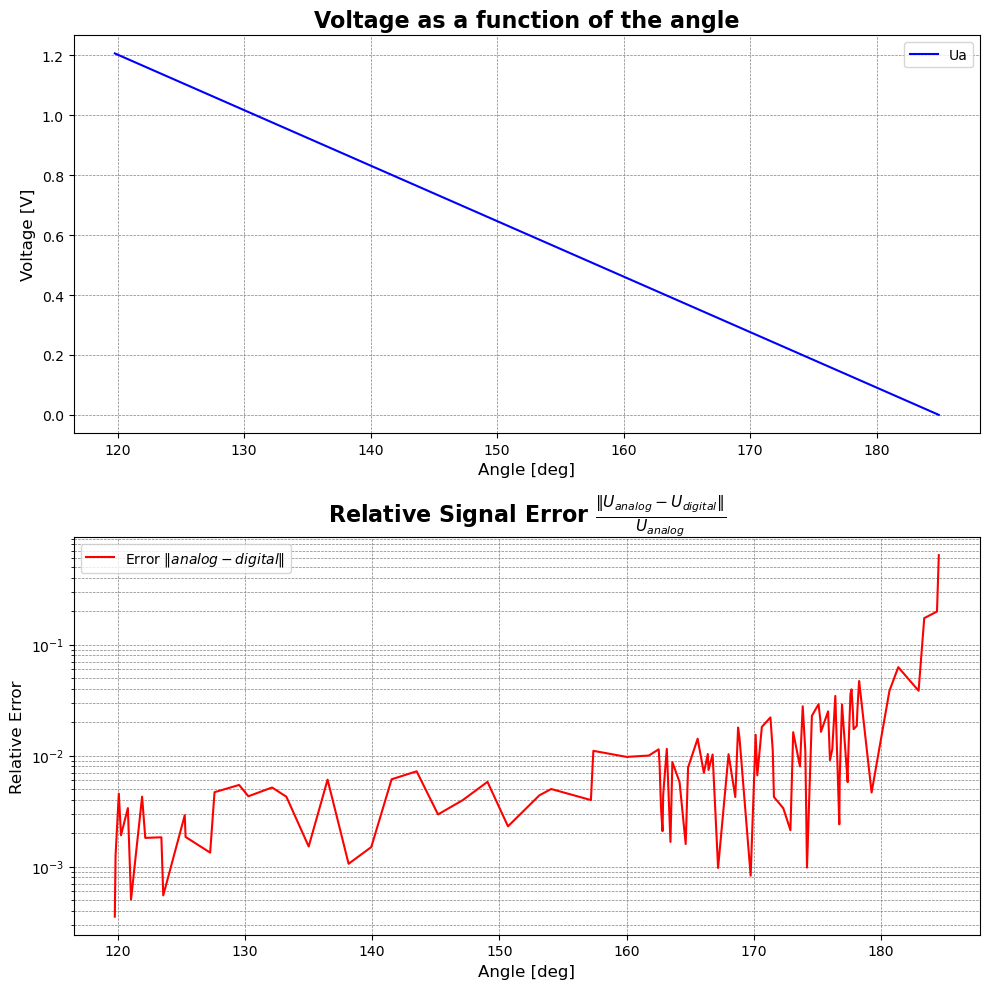

In [50]:
# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(theta_vals, Ua_vals, label='Ua', color='blue')
ax[0].set_xlabel('Angle [deg]', fontsize=12)
ax[0].set_ylabel('Voltage [V]', fontsize=12)
ax[0].set_title('Voltage as a function of the angle', fontsize=16, fontweight='bold')
ax[0].grid(which='both', axis='both', linestyle='--', color='gray', linewidth=0.5)
ax[0].legend()

ax[1].semilogy(theta_vals[:-1], error[:-1], label=r'Error $\|analog - digital\|$', color='red')
ax[1].set_xlabel('Angle [deg]', fontsize=12)
ax[1].set_ylabel('Relative Error', fontsize=12)
ax[1].set_title(r'Relative Signal Error $\frac{\|U_{analog} - U_{digital}\|}{U_{analog}}$', fontsize=16, fontweight='bold')
ax[1].grid(which='both', axis='both', linestyle='--', color='gray', linewidth=0.5)
ax[1].legend()

plt.tight_layout()
plt.show()

-----------------------------------------------

## References